In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from ipywidgets import interact, SelectionSlider, IntSlider

In [2]:
import metadata_util
spec_names = metadata_util.read_spec_names()
phy_names = metadata_util.get_phy_names()
jval_names = metadata_util.read_jval_names()

In [3]:
import sys
sys.path.append("../../GEOSChem/KPP4GC/GC_12_Standard/") # dirty fix to allow importing
import kpp4py

In [4]:
ds = xr.open_dataset('./KPP_fields_100.nc')
ds.coords['nspec'] = spec_names
ds.coords['nphotol'] = jval_names
ds.coords['nphy'] = phy_names
ds

<xarray.Dataset>
Dimensions:   (lat: 46, lev: 72, lon: 72, nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
  * nspec     (nspec) <U8 'CH2I2' 'CH2ICl' 'CH2IBr' 'AERI' 'CO2' 'INDIOL' ...
  * nphotol   (nphotol) object '1/O2/O2' '2/O3/O3' '3/O3/O3(1D)' '4/H2O/H2O' ...
  * nphy      (nphy) <U6 'TEMP' 'PRESS' 'NUMDEN' 'H2O'
Dimensions without coordinates: lat, lev, lon, nreact
Data variables:
    C_before  (lev, lat, lon, nspec) float64 ...
    C_after   (lev, lat, lon, nspec) float64 ...
    PHOTOL    (lev, lat, lon, nphotol) float64 ...
    PHY       (lev, lat, lon, nphy) float64 ...
    RCONST    (lev, lat, lon, nreact) float64 ...

In [5]:
ds_mean = ds.mean(dim=['lev', 'lat', 'lon'])
ds_mean

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
  * nspec     (nspec) <U8 'CH2I2' 'CH2ICl' 'CH2IBr' 'AERI' 'CO2' 'INDIOL' ...
  * nphotol   (nphotol) object '1/O2/O2' '2/O3/O3' '3/O3/O3(1D)' '4/H2O/H2O' ...
  * nphy      (nphy) <U6 'TEMP' 'PRESS' 'NUMDEN' 'H2O'
Dimensions without coordinates: nreact
Data variables:
    C_before  (nspec) float64 1.803e+04 2.358e+05 3.319e+04 9.041e+05 0.0 ...
    C_after   (nspec) float64 1.358e+04 2.232e+05 2.919e+04 9.041e+05 ...
    PHOTOL    (nphotol) float64 2.057e-11 0.0002036 0.0001275 0.0 0.0 ...
    PHY       (nphy) float64 200.6 296.9 8.097e+18 5.378e+16
    RCONST    (nreact) float64 6.37e-15 3.152e-14 1.107e-15 7.199e-18 ...

# Choose reference point

In [6]:
ref_c_before = ds_mean['C_before'].values
ref_phy = ds_mean['PHY'].values
ref_photol = ds_mean['PHOTOL'].values

ref_c_before.shape, ref_phy.shape, ref_photol.shape

((240,), (4,), (130,))

In [7]:
ref_features = np.r_[ref_c_before, ref_phy, ref_photol]
ref_features.shape

(374,)

In [8]:
ref_c_after = kpp4py.onestep(ref_c_before, ref_phy, ref_photol).ravel()
ref_c_after.shape

(240,)

In [9]:
n_c = ref_c_before.shape[0]
n_phy = ref_phy.shape[0]
n_jv = ref_photol.shape[0]

n_features = n_c + n_phy + n_jv
n_features

374

# Change a particular input variable

In [10]:
var = 'O3'
idx = spec_names.index(var)
idx

230

In [11]:
original_sample = ds['C_before'].sel(nspec=var).values.ravel()
original_sample.shape

(238464,)

(<matplotlib.lines.Line2D at 0x1c22657160>,)

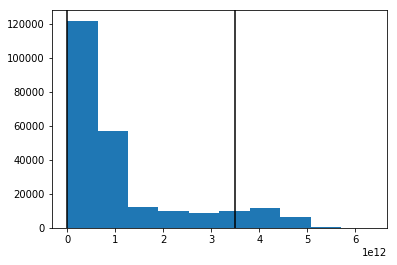

In [12]:
q0 = np.quantile(original_sample, 0.1)
q1 = np.quantile(original_sample, 0.9)
plt.hist(original_sample)
plt.axvline(q0, c='k'); plt.axvline(q1, c='k'),

In [13]:
# change this particular feature
n_grid = 20

grid_features = np.empty([n_grid, n_features])
grid_features[:] = ref_features

grid_x = np.linspace(q0, q1, n_grid)
grid_features[:,idx] = grid_x

In [14]:
def solve_kpp(features):
    c_before = features[:,0:n_c]
    phy = features[:,n_c:n_c+n_phy]
    jvals = features[:,n_c+n_phy:]
    
    c_after = kpp4py.onestep(c_before.T, 
                             phy.T, 
                             jvals.T).T
    return c_after

In [15]:
grid_result = solve_kpp(grid_features)
grid_result.shape

(20, 240)

# Examine response

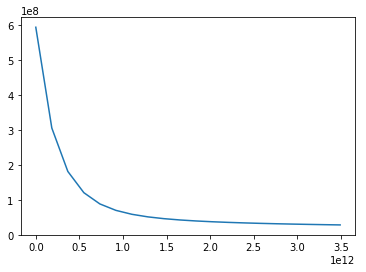

In [16]:
idy = spec_names.index('NO')

plt.plot(grid_x, grid_result[:,idy])

In [17]:
@interact(var=SelectionSlider(options=spec_names))
def plot_response(var):
    idy = spec_names.index(var)
    plt.plot(grid_x, grid_result[:,idy])
    plt.ylabel(var)

interactive(children=(SelectionSlider(description='var', options=('CH2I2', 'CH2ICl', 'CH2IBr', 'AERI', 'CO2', …

In [18]:
df_result = pd.DataFrame(grid_result, columns=spec_names)
df_result.head()

,CH2I2,CH2ICl,CH2IBr,AERI,CO2,INDIOL,ISALA,ISALC,ISN1OA,ISN1OG,...,O3,HO2,ClO,OH,H2O,H2,MOH,N2,O2,RCOOH
0,11.124297,199950.044624,19320.979070,904082.125144,1.019021e+09,8.935689e+07,161999.912947,10538.932843,458691.457937,502356.294602,...,1.274422e+11,9.620198e+07,8.244200e+05,8.015144e+06,5.382779e+16,4.048405e+12,6.433087e+09,6.321989e+18,1.696282e+18,0.080968
1,11.255565,199950.045484,19320.988235,904082.125144,2.428186e+09,8.935689e+07,161999.912947,10538.932843,458691.457937,542704.592917,...,3.097440e+11,1.505395e+08,2.621343e+06,1.531621e+07,5.382779e+16,4.048405e+12,6.433087e+09,6.321989e+18,1.696282e+18,0.080968
2,11.913004,199950.049678,19321.033456,904082.125144,3.695782e+09,8.935689e+07,161999.912947,10538.932843,458691.457937,560281.038093,...,4.916321e+11,1.866244e+08,4.307654e+06,2.235432e+07,5.382779e+16,4.048405e+12,6.433087e+09,6.321989e+18,1.696282e+18,0.080968
3,12.415569,199950.052775,19321.067166,904082.125144,4.921731e+09,8.935689e+07,161999.912947,10538.932843,458691.457937,568597.361123,...,6.734225e+11,2.144404e+08,5.515336e+06,2.938820e+07,5.382779e+16,4.048405e+12,6.433087e+09,6.321989e+18,1.696282e+18,0.080968
4,12.665505,199950.054258,19321.083359,904082.125144,6.119673e+09,8.935689e+07,161999.912947,10538.932843,458691.457937,572541.812136,...,8.551628e+11,2.376530e+08,6.301816e+06,3.632950e+07,5.382779e+16,4.048405e+12,6.433087e+09,6.321989e+18,1.696282e+18,0.080968


In [19]:
df_rel_change = (df_result.max() - df_result.min())/df_result.median()

In [20]:
df_rel_change.nlargest(20)

LIMO       7.151169e+20
IBr        4.140036e+10
ISOP       1.257273e+09
MACROO     8.862993e+07
MVKOO      8.661228e+07
DIBOO      9.461841e+06
ISOPND     3.824716e+06
RIPB       1.510975e+06
RIPD       1.502740e+06
DHPCARP    1.453527e+06
RIO2       8.792989e+05
HC5        6.699459e+05
RIPA       2.634702e+05
MTPA       1.895040e+05
MTPO       1.895040e+05
OLNN       8.603408e+04
OLND       8.168183e+04
ISOPNB     7.755295e+04
GAOO       4.690312e+04
MOBA       4.383460e+03
dtype: float64

In [21]:
df_rel_change.nsmallest(40)

AERI        0.000000e+00
ISALA       0.000000e+00
ISALC       0.000000e+00
ISN1OA      0.000000e+00
LVOCOA      0.000000e+00
SOAGX       0.000000e+00
SOAIE       0.000000e+00
SOAME       0.000000e+00
SOAMG       0.000000e+00
BrSALC      0.000000e+00
BrSALA      0.000000e+00
H2          0.000000e+00
MOH         0.000000e+00
N2          0.000000e+00
O2          0.000000e+00
RCOOH       0.000000e+00
INDIOL      3.835482e-15
DHDC        3.487115e-09
H2O         7.909123e-09
CFC115      3.463939e-08
CH2ICl      5.987170e-08
H1301       1.018120e-07
CFC114      2.137403e-07
H1211       2.383889e-07
H2402       2.979862e-07
CFC12       2.989795e-07
N2O         3.260212e-07
CFC113      4.320800e-07
CFC11       5.026034e-07
CCl4        7.047374e-07
MONITA      4.934424e-06
IONITA      4.934424e-06
CH2IBr      6.726658e-06
HCFC142b    3.757671e-05
OCS         5.402670e-05
CH4         6.827301e-05
HCFC22      7.520871e-05
HCFC141b    8.395256e-05
CH3CCl3     1.632620e-04
CH3Br       8.948233e-04


# Fitting

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [23]:
changed_spec = df_result.columns[df_rel_change > 0.01]
changed_spec

Index(['CH2I2', 'CO2', 'ISN1OG', 'LBRO2H', 'LBRO2N', 'LISOPOH', 'LISOPNO3',
       'LTRO2H', 'LTRO2N', 'LVOC',
       ...
       'HCl', 'O1D', 'Cl', 'O', 'NO3', 'NO2', 'O3', 'HO2', 'ClO', 'OH'],
      dtype='object', length=188)

In [24]:
Y_train = StandardScaler().fit_transform(df_result[changed_spec].values)
Y_train.shape

(20, 188)

In [25]:
X_train = StandardScaler().fit_transform(grid_x.reshape(-1, 1))
X_train.shape

(20, 1)

In [26]:
model = Sequential([
    Dense(20, input_shape=(X_train.shape[1],)),
    Activation('tanh'),
    Dense(50),
    Activation('tanh'),
    Dense(Y_train.shape[1])
])

model.compile(optimizer='adam', loss='mse')

In [27]:
%%time
model.fit(X_train, Y_train, epochs=5000, verbose=0)
model.fit(X_train, Y_train, epochs=2, verbose=1)

Epoch 1/2
20/20 [==============================] - 0s 42us/step - loss: 7.3082e-06
Epoch 2/2
20/20 [==============================] - 0s 55us/step - loss: 8.0913e-06
CPU times: user 6.36 s, sys: 1.11 s, total: 7.47 s
Wall time: 4.41 s


In [28]:
Y_pred_train = model.predict(X_train)
r2_score(Y_pred_train, Y_train)

0.99998871401209

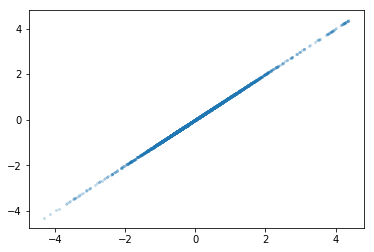

In [29]:
# almost perfect
plt.scatter(Y_pred_train, Y_train, alpha=0.2, s=4)